# Linear Regression for Price Prediction

This notebook implements a linear regression model to predict price changes for Squid_Ink using technical indicators as features.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Add backtester package to path
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Load Data

First, let's load the Squid_Ink price data and limit it to the first 20,000 timestamps (in-sample data).

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
VWAP range: 1832.0 to 2187.3880597014927
Calculated 19999 return data points


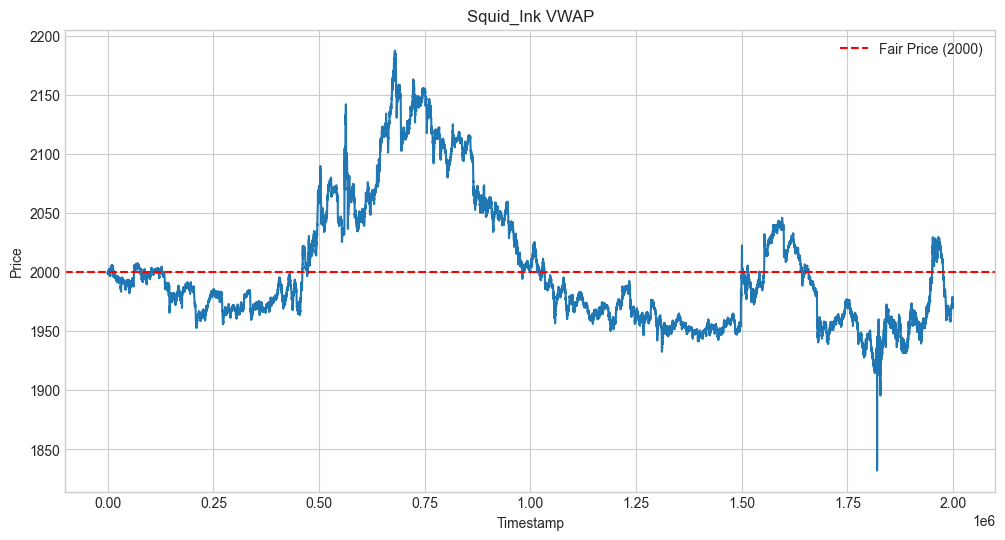

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Extract VWAP for analysis
squid_vwap = in_sample_prices['vwap']
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate returns
returns = squid_vwap.pct_change().dropna()
log_returns = np.log(squid_vwap).diff().dropna()
print(f"Calculated {len(returns)} return data points")

# Plot VWAP
plt.figure(figsize=(12, 6))
plt.plot(squid_vwap)
plt.axhline(y=2000, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 2. Implement Technical Indicators

Now, let's implement the technical indicators we'll use as features for our linear regression model:

1. CMMA (Cumulative Moving Average Momentum)
2. MACD (Moving Average Convergence Divergence)
3. Stochastic Oscillator

In [9]:
def cmma(price_series, lookback=10):
    """
    Compute the Cumulative Moving Average Momentum (CMMA).
    
    Parameters:
        price_series (pd.Series): Series of prices
        lookback (int): Lookback period
        
    Returns:
        pd.Series: CMMA indicator (0-1 range)
    """
    # Calculate raw CMMA
    raw_cmma = (price_series - price_series.rolling(lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    
    # Normalize using sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    return sigmoid(raw_cmma)

def macd(price_series, short_lookback=12, long_lookback=26, signal_lookback=9):
    """
    Compute the Moving Average Convergence Divergence (MACD).
    
    Parameters:
        price_series (pd.Series): Series of prices
        short_lookback (int): Lookback period for short-term EMA
        long_lookback (int): Lookback period for long-term EMA
        signal_lookback (int): Lookback period for signal line
        
    Returns:
        tuple: (MACD line, Signal line, Histogram)
    """
    # Calculate EMAs
    short_ema = price_series.ewm(span=short_lookback, adjust=False).mean()
    long_ema = price_series.ewm(span=long_lookback, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate Signal line
    signal_line = macd_line.ewm(span=signal_lookback, adjust=False).mean()
    
    # Calculate Histogram
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

def stochastic_oscillator(prices, k_period=14, d_period=3):
    """
    Calculate the Stochastic Oscillator (%K and %D).
    
    Parameters:
        prices (pd.Series): Series of prices
        k_period (int): Period for %K calculation
        d_period (int): Period for %D calculation (moving average of %K)
        
    Returns:
        tuple: (%K, %D) - both are pandas Series
    """
    # Calculate %K
    low_min = prices.rolling(window=k_period).min()
    high_max = prices.rolling(window=k_period).max()
    
    # Avoid division by zero
    denominator = high_max - low_min
    denominator = denominator.replace(0, np.nan)
    
    k = ((prices - low_min) / denominator)
    
    # Calculate %D (moving average of %K)
    d = k.rolling(window=d_period).mean()
    
    return k, d

## 3. Calculate Indicators and Visualize

Now, let's calculate the indicators for our price data and visualize them.

In [10]:
# Define lookback periods for CMMA
cmma_lookbacks = [10, 20, 50]

# Calculate CMMA for different lookback periods
cmma_indicators = {}
for lookback in cmma_lookbacks:
    cmma_indicators[f'CMMA_{lookback}'] = cmma(squid_vwap, lookback)

# Calculate MACD
macd_line, macd_signal, macd_hist = macd(squid_vwap)

# Calculate Stochastic Oscillator
stoch_k, stoch_d = stochastic_oscillator(squid_vwap)

# Create a DataFrame with all indicators
indicators_df = pd.DataFrame({
    'CMMA_10': cmma_indicators['CMMA_10'],
    'CMMA_20': cmma_indicators['CMMA_20'],
    'CMMA_50': cmma_indicators['CMMA_50'],
    'MACD_Line': macd_line,
    'MACD_Signal': macd_signal,
    'MACD_Hist': macd_hist,
    'Stoch_K': stoch_k,
    'Stoch_D': stoch_d
})

# Display the first few rows
indicators_df.head()

,CMMA_10,CMMA_20,CMMA_50,MACD_Line,MACD_Signal,MACD_Hist,Stoch_K,Stoch_D
timestamp,,,,,,,,
0,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
100,NaN,NaN,NaN,-0.057874,-0.011575,-0.046299,NaN,NaN
200,NaN,NaN,NaN,-0.125742,-0.034408,-0.091334,NaN,NaN
300,NaN,NaN,NaN,-0.216081,-0.070743,-0.145339,NaN,NaN
400,NaN,NaN,NaN,-0.324284,-0.121451,-0.202833,NaN,NaN


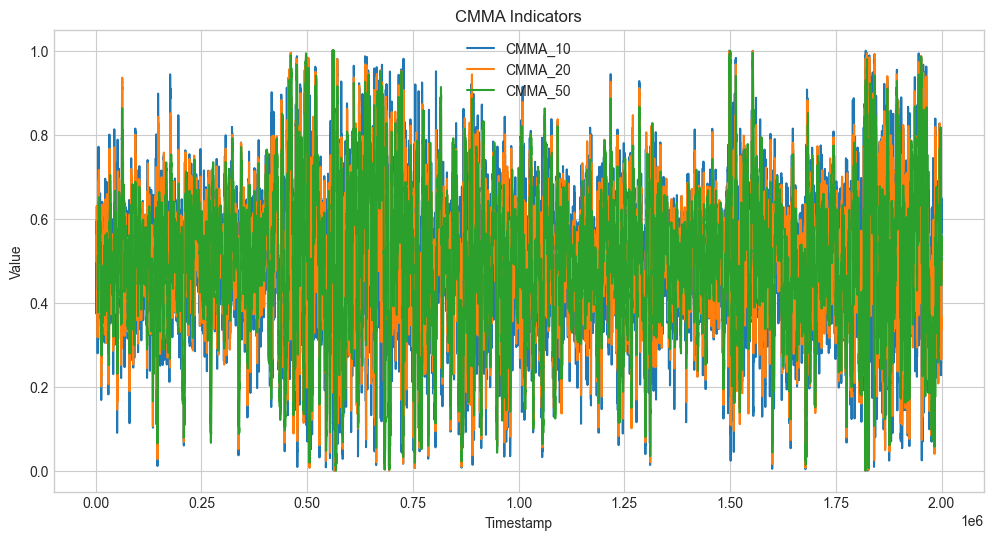

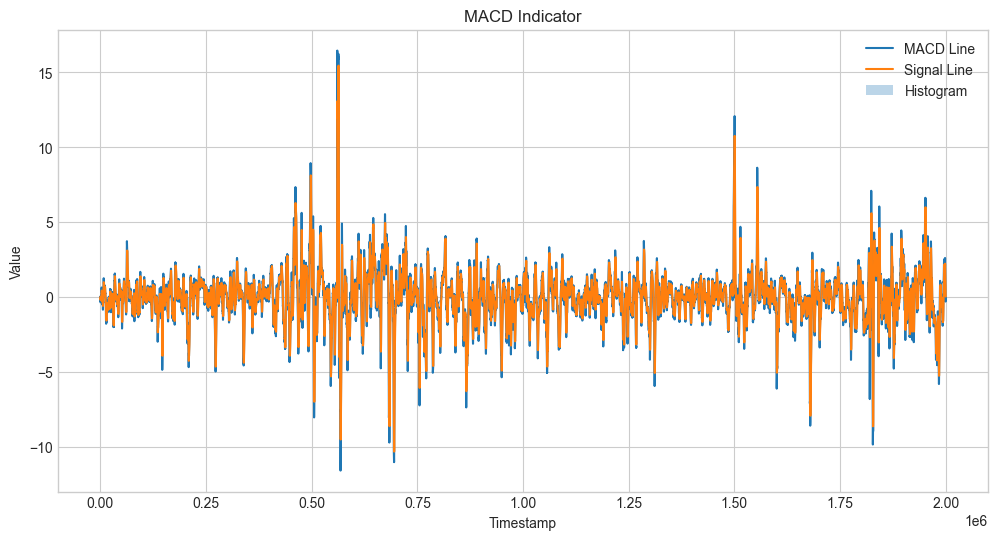

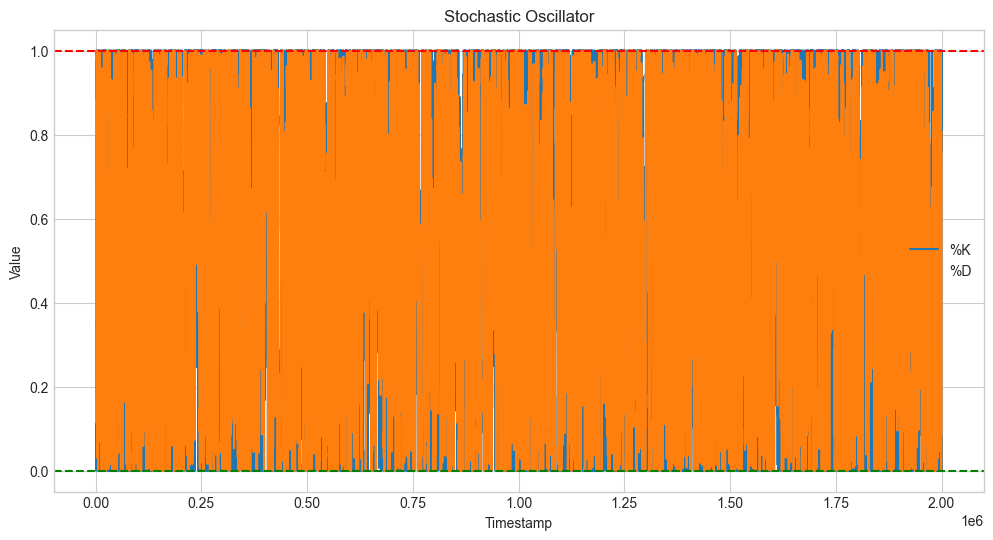

In [15]:
# Plot CMMA indicators
plt.figure(figsize=(12, 6))
for lookback in cmma_lookbacks:
    plt.plot(cmma_indicators[f'CMMA_{lookback}'], label=f'CMMA_{lookback}')
plt.title('CMMA Indicators')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot MACD
plt.figure(figsize=(12, 6))
plt.plot(macd_line, label='MACD Line')
plt.plot(macd_signal, label='Signal Line')
plt.bar(macd_hist.index, macd_hist, label='Histogram', alpha=0.3)
plt.title('MACD Indicator')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot Stochastic Oscillator
plt.figure(figsize=(12, 6))
plt.plot(stoch_k, label='%K')
plt.plot(stoch_d, label='%D')
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.title('Stochastic Oscillator')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 4. Calculate Correlation Between Indicators

Let's calculate the correlation between our indicators to understand their relationships.

In [16]:
# Calculate correlation matrix
correlation_matrix = indicators_df.corr()

# Display correlation matrix
correlation_matrix

,CMMA_10,CMMA_20,CMMA_50,MACD_Line,MACD_Signal,MACD_Hist,Stoch_K,Stoch_D
CMMA_10,1.000000,0.879560,0.609690,0.461589,0.252905,0.750868,0.836753,0.763178
CMMA_20,0.879560,1.000000,0.804635,0.728588,0.536908,0.747889,0.814889,0.823995
CMMA_50,0.609690,0.804635,1.000000,0.919129,0.871724,0.326149,0.578126,0.614075
MACD_Line,0.461589,0.728588,0.919129,1.000000,0.954936,0.334174,0.429968,0.514193
MACD_Signal,0.252905,0.536908,0.871724,0.954936,1.000000,0.039365,0.265936,0.341065
MACD_Hist,0.750868,0.747889,0.326149,0.334174,0.039365,1.000000,0.603038,0.648013
Stoch_K,0.836753,0.814889,0.578126,0.429968,0.265936,0.603038,1.000000,0.902814
Stoch_D,0.763178,0.823995,0.614075,0.514193,0.341065,0.648013,0.902814,1.000000


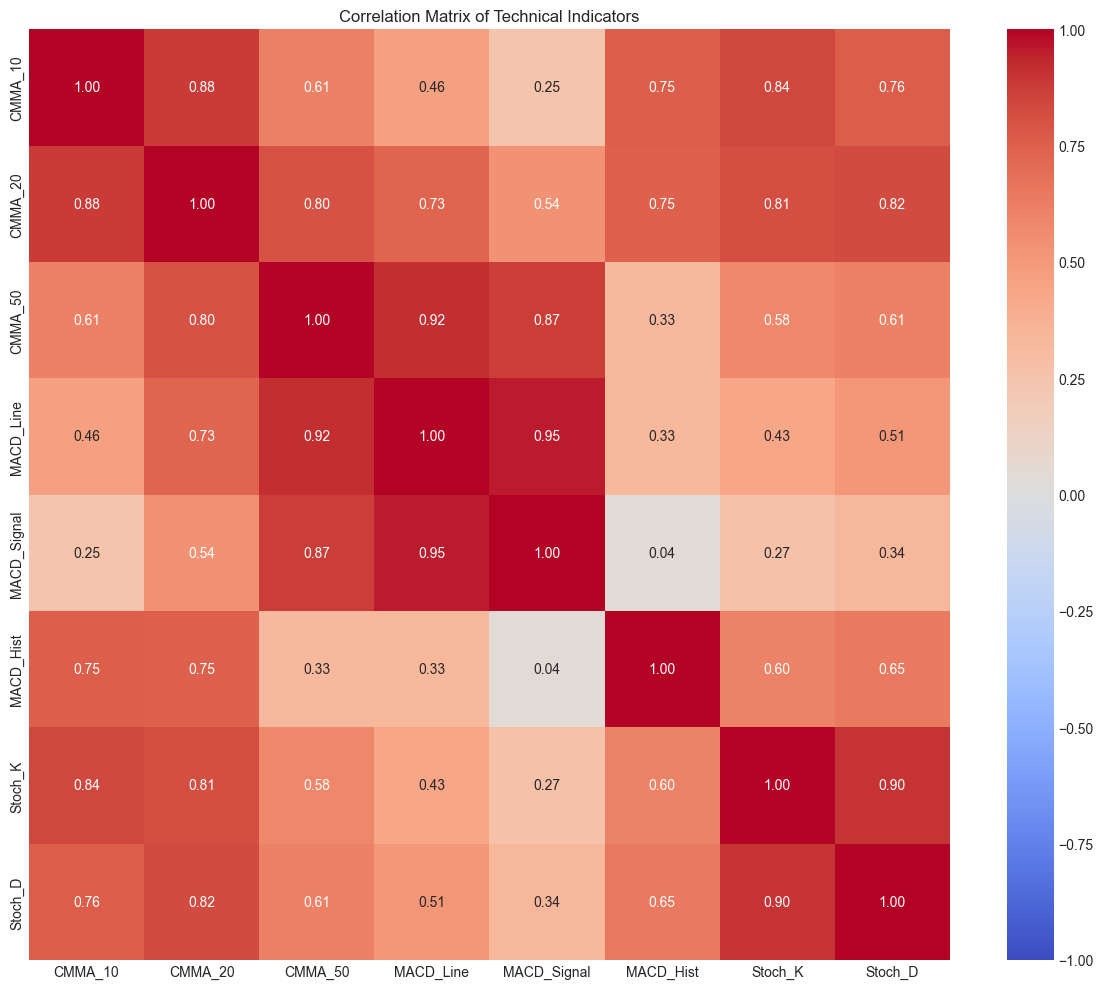

Correlation with Future Returns:
CMMA_10       -0.020722
CMMA_20       -0.010409
CMMA_50       -0.010355
MACD_Line     -0.010049
MACD_Signal   -0.001261
MACD_Hist     -0.029825
Stoch_K       -0.017438
Stoch_D        0.004829
Name: Future_Return, dtype: float64


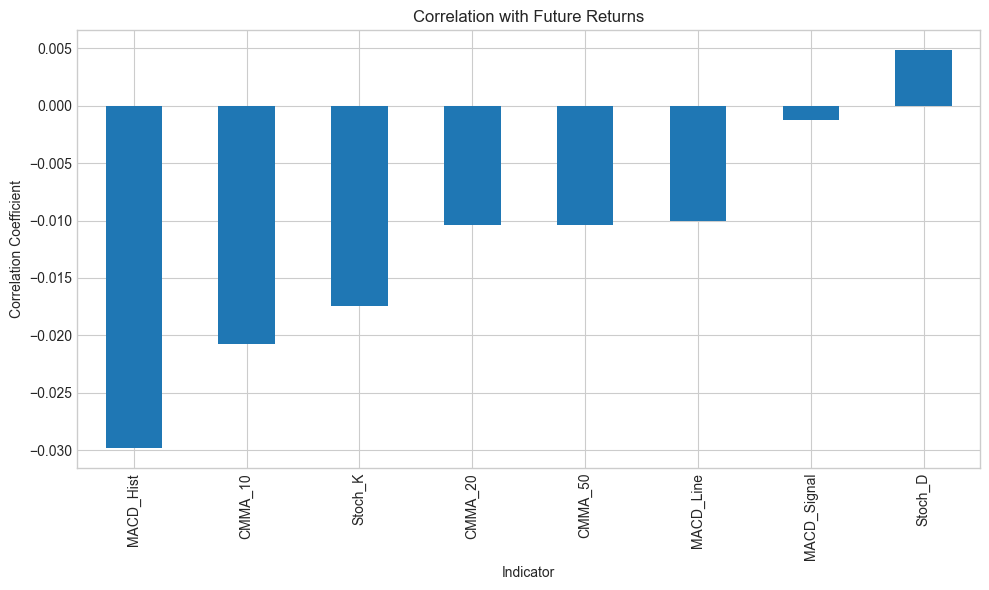

In [19]:
# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Technical Indicators')
plt.tight_layout()
plt.show()

# Analyze correlation with future returns
# Create a DataFrame with indicators and future returns
future_returns = log_returns.shift(-1)  # Next period return

# Combine indicators with future returns
combined_df = pd.DataFrame({
    'Future_Return': future_returns,
    'CMMA_10': cmma_indicators['CMMA_10'],
    'CMMA_20': cmma_indicators['CMMA_20'],
    'CMMA_50': cmma_indicators['CMMA_50'],
    'MACD_Line': macd_line,
    'MACD_Signal': macd_signal,
    'MACD_Hist': macd_hist,
    'Stoch_K': stoch_k,
    'Stoch_D': stoch_d
}).dropna()

# Calculate correlation with future returns
future_return_corr = combined_df.corr()['Future_Return'].drop('Future_Return')

# Display correlation with future returns
print("Correlation with Future Returns:")
print(future_return_corr)

# Plot correlation with future returns
plt.figure(figsize=(10, 6))
future_return_corr.sort_values().plot(kind='bar')
plt.title('Correlation with Future Returns')
plt.xlabel('Indicator')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Prepare Data for Linear Regression

Now, let's prepare our data for linear regression by creating features and target variables.

In [21]:
# Prepare features and target
X = combined_df.drop('Future_Return', axis=1)
y = combined_df['Future_Return']

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Display feature statistics
print("Feature Statistics:")
X.describe()

Training set size: 15959
Testing set size: 3990
Feature Statistics:


,CMMA_10,CMMA_20,CMMA_50,MACD_Line,MACD_Signal,MACD_Hist,Stoch_K,Stoch_D
count,1.994900e+04,1.994900e+04,19949.000000,19949.000000,19949.000000,19949.000000,19949.000000,19949.000000
mean,5.011384e-01,5.005988e-01,0.499601,-0.009831,-0.009868,0.000037,0.520519,0.520486
std,1.652877e-01,1.690118e-01,0.173932,1.833932,1.729859,0.544717,0.371695,0.340966
min,2.633579e-14,1.888923e-10,0.000001,-11.602302,-10.333909,-8.019185,0.000000,0.000000
25%,4.048285e-01,3.989677e-01,0.393315,-0.829819,-0.788240,-0.241878,0.154104,0.189948
50%,5.073952e-01,5.071475e-01,0.509891,0.069348,0.065944,0.000375,0.537415,0.541993
75%,6.012886e-01,6.061402e-01,0.605638,0.840203,0.786569,0.245835,0.887291,0.850851
max,1.000000e+00,9.999973e-01,0.999941,16.461776,15.458651,7.841432,1.000000,1.000000


## 6. Train Linear Regression Model

Now, let's train a linear regression model to predict future price changes.

Model Coefficients:


,Feature,Coefficient
3,MACD_Line,3.645274e+09
1,CMMA_20,5.506441e-04
7,Stoch_D,2.483267e-04
2,CMMA_50,1.046731e-04
0,CMMA_10,-1.418047e-04
6,Stoch_K,-3.255309e-04
4,MACD_Signal,-3.645274e+09
5,MACD_Hist,-3.645274e+09


<Figure size 1000x600 with 0 Axes>

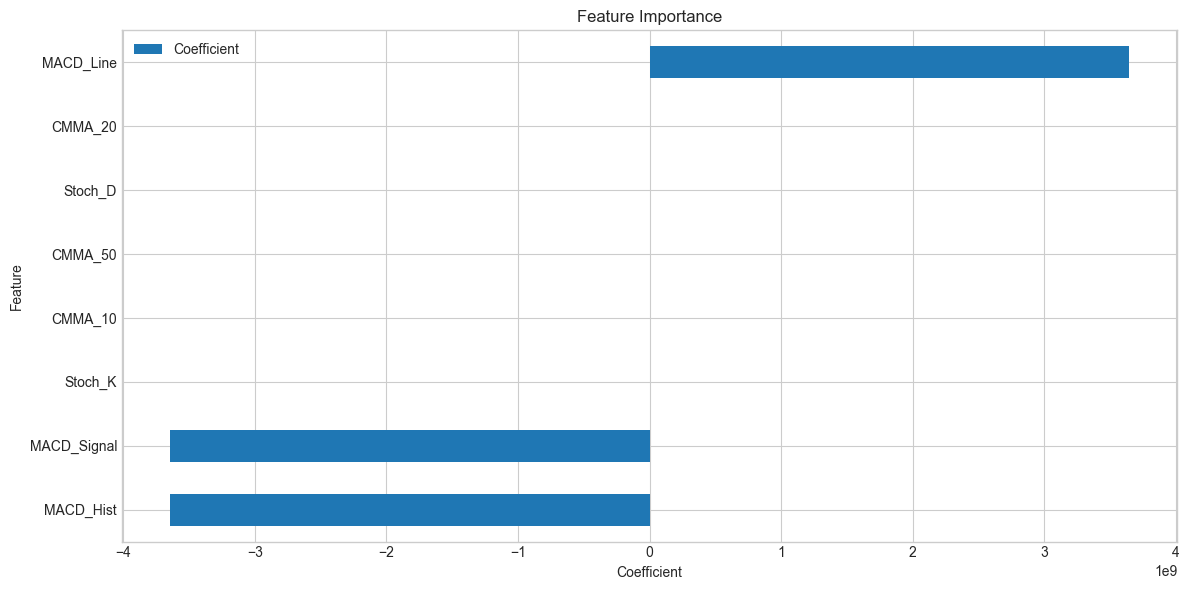

In [22]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print("Model Coefficients:")
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)
display(coefficients)

# Plot feature importance
plt.figure(figsize=(10, 6))
coefficients.sort_values('Coefficient').plot(x='Feature', y='Coefficient', kind='barh')
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

Training MSE: 0.00000058
Testing MSE: 0.00000210
Training R²: 0.0043
Testing R²: 0.0015


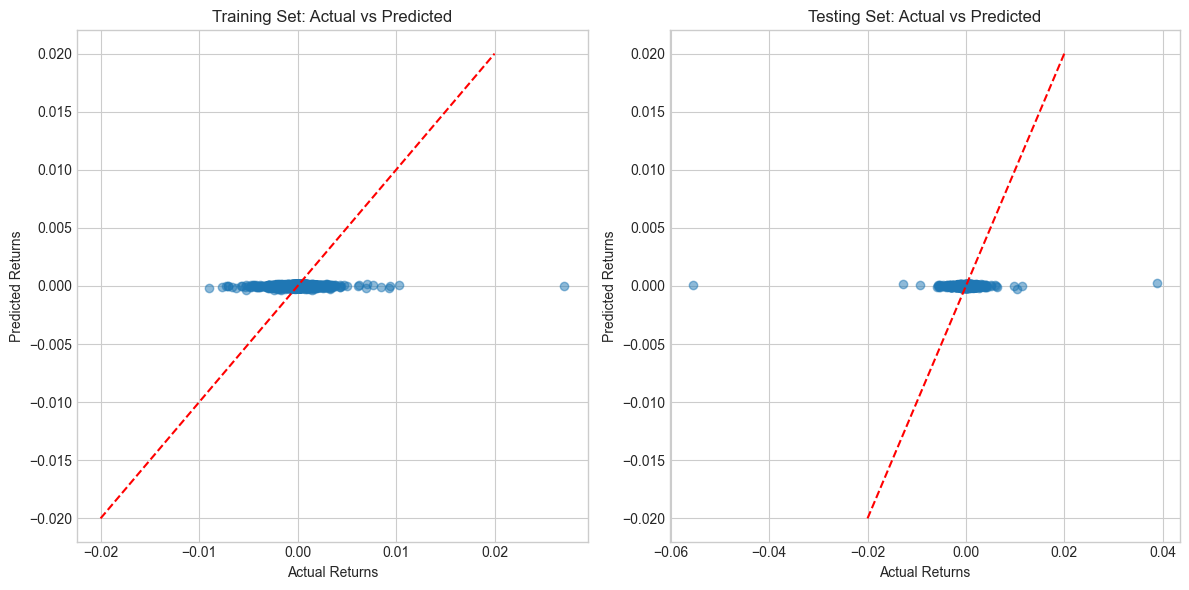

In [23]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.8f}")
print(f"Testing MSE: {test_mse:.8f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([-0.02, 0.02], [-0.02, 0.02], 'r--')
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([-0.02, 0.02], [-0.02, 0.02], 'r--')
plt.title('Testing Set: Actual vs Predicted')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Implement Trading Strategy

Now, let's implement a trading strategy based on our linear regression predictions.

In [24]:
# Generate predictions for the entire dataset
all_predictions = model.predict(X)

# Create a DataFrame with predictions
prediction_df = pd.DataFrame({
    'Actual_Return': y,
    'Predicted_Return': all_predictions
}, index=X.index)

# Generate trading signals
# Buy when predicted return is positive, sell when negative
prediction_df['Signal'] = 0  # Initialize with no position
prediction_df.loc[prediction_df['Predicted_Return'] > 0, 'Signal'] = 1  # Buy signal
prediction_df.loc[prediction_df['Predicted_Return'] < 0, 'Signal'] = -1  # Sell signal

# Calculate position changes for transaction costs
prediction_df['Position_Change'] = prediction_df['Signal'].diff().fillna(0)

# Calculate transaction costs (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 1.5/2000  # 0.075% per dollar traded
prediction_df['Transaction_Cost'] = 0.0
prediction_df.loc[prediction_df['Position_Change'] != 0, 'Transaction_Cost'] = transaction_cost

# Calculate strategy returns (with transaction costs)
prediction_df['Strategy_Return'] = prediction_df['Signal'].shift(1) * prediction_df['Actual_Return'] - prediction_df['Transaction_Cost']

# Calculate strategy returns (without transaction costs)
prediction_df['Strategy_Return_No_Costs'] = prediction_df['Signal'].shift(1) * prediction_df['Actual_Return']

# Calculate cumulative returns
prediction_df['Cumulative_Return'] = (1 + prediction_df['Strategy_Return'].fillna(0)).cumprod() - 1
prediction_df['Cumulative_Return_No_Costs'] = (1 + prediction_df['Strategy_Return_No_Costs'].fillna(0)).cumprod() - 1
prediction_df['Buy_Hold_Return'] = (1 + prediction_df['Actual_Return'].fillna(0)).cumprod() - 1

# Display the first few rows
prediction_df.head()

,Actual_Return,Predicted_Return,Signal,Position_Change,Transaction_Cost,Strategy_Return,Strategy_Return_No_Costs,Cumulative_Return,Cumulative_Return_No_Costs,Buy_Hold_Return
timestamp,,,,,,,,,,
5000,0.000033,-0.000012,-1,0.0,0.0,NaN,NaN,0.000000,0.000000,0.000033
5100,0.000250,-0.000023,-1,0.0,0.0,-0.000250,-0.000250,-0.000250,-0.000250,0.000283
5200,0.000239,-0.000038,-1,0.0,0.0,-0.000239,-0.000239,-0.000489,-0.000489,0.000523
5300,0.000261,-0.000045,-1,0.0,0.0,-0.000261,-0.000261,-0.000750,-0.000750,0.000784
5400,0.000004,-0.000067,-1,0.0,0.0,-0.000004,-0.000004,-0.000754,-0.000754,0.000788


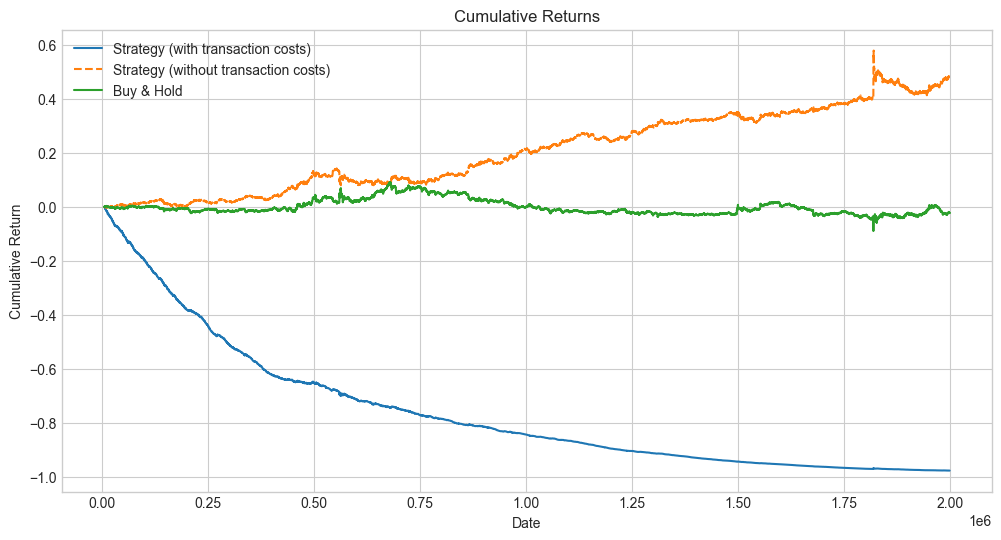

Performance Metrics:


C:\Users\fujos\AppData\Local\Temp\ipykernel_61224\2287965248.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-97.78%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_df.loc[i, col] = f"{metrics_df.loc[i, col]:.2%}"
C:\Users\fujos\AppData\Local\Temp\ipykernel_61224\2287965248.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.73%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_df.loc[i, col] = f"{metrics_df.loc[i, col]:.2%}"
C:\Users\fujos\AppData\Local\Temp\ipykernel_61224\2287965248.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.19%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

,Metric,Strategy (with costs),Strategy (no costs),Buy & Hold
0,Total Return,-97.78%,47.73%,-2.19%
1,Annualized Return,-4.69%,0.49%,-0.03%
2,Annualized Volatility,1.60%,1.49%,1.49%
3,Sharpe Ratio,-293.63%,33.11%,-1.87%
4,Maximum Drawdown,-97.80%,-16.55%,-18.12%
5,Win Rate,37.96%,48.13%,48.15%
6,Number of Trades,5592,5592,1


In [26]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(prediction_df['Cumulative_Return'], label='Strategy (with transaction costs)')
plt.plot(prediction_df['Cumulative_Return_No_Costs'], label='Strategy (without transaction costs)', linestyle='--')
plt.plot(prediction_df['Buy_Hold_Return'], label='Buy & Hold')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Calculate performance metrics
strategy_returns = prediction_df['Strategy_Return'].dropna()
strategy_returns_no_costs = prediction_df['Strategy_Return_No_Costs'].dropna()
buy_hold_returns = prediction_df['Actual_Return'].dropna()

# Calculate total returns
strategy_total_return = prediction_df['Cumulative_Return'].iloc[-1]
strategy_total_return_no_costs = prediction_df['Cumulative_Return_No_Costs'].iloc[-1]
buy_hold_total_return = prediction_df['Buy_Hold_Return'].iloc[-1]

# Calculate annualized returns
trading_days = 252
strategy_annual_return = (1 + strategy_total_return) ** (trading_days / len(strategy_returns)) - 1
strategy_annual_return_no_costs = (1 + strategy_total_return_no_costs) ** (trading_days / len(strategy_returns_no_costs)) - 1
buy_hold_annual_return = (1 + buy_hold_total_return) ** (trading_days / len(buy_hold_returns)) - 1

# Calculate volatility
strategy_volatility = strategy_returns.std() * np.sqrt(trading_days)
strategy_volatility_no_costs = strategy_returns_no_costs.std() * np.sqrt(trading_days)
buy_hold_volatility = buy_hold_returns.std() * np.sqrt(trading_days)

# Calculate Sharpe ratio
strategy_sharpe = strategy_annual_return / strategy_volatility if strategy_volatility != 0 else 0
strategy_sharpe_no_costs = strategy_annual_return_no_costs / strategy_volatility_no_costs if strategy_volatility_no_costs != 0 else 0
buy_hold_sharpe = buy_hold_annual_return / buy_hold_volatility if buy_hold_volatility != 0 else 0

# Calculate maximum drawdown
strategy_drawdown = (prediction_df['Cumulative_Return'] - prediction_df['Cumulative_Return'].cummax()).min()
strategy_drawdown_no_costs = (prediction_df['Cumulative_Return_No_Costs'] - prediction_df['Cumulative_Return_No_Costs'].cummax()).min()
buy_hold_drawdown = (prediction_df['Buy_Hold_Return'] - prediction_df['Buy_Hold_Return'].cummax()).min()

# Calculate win rate
strategy_win_rate = (strategy_returns > 0).mean()
strategy_win_rate_no_costs = (strategy_returns_no_costs > 0).mean()
buy_hold_win_rate = (buy_hold_returns > 0).mean()

# Calculate number of trades
num_trades = (prediction_df['Position_Change'] != 0).sum()

# Display performance metrics
print("Performance Metrics:")

metrics_df = pd.DataFrame({
    'Metric': ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Maximum Drawdown', 'Win Rate', 'Number of Trades'],
    'Strategy (with costs)': [strategy_total_return, strategy_annual_return, strategy_volatility, strategy_sharpe, strategy_drawdown, strategy_win_rate, num_trades],
    'Strategy (no costs)': [strategy_total_return_no_costs, strategy_annual_return_no_costs, strategy_volatility_no_costs, strategy_sharpe_no_costs, strategy_drawdown_no_costs, strategy_win_rate_no_costs, num_trades],
    'Buy & Hold': [buy_hold_total_return, buy_hold_annual_return, buy_hold_volatility, buy_hold_sharpe, buy_hold_drawdown, buy_hold_win_rate, 1]
})

# Format percentages
for col in metrics_df.columns[1:]:
    for i in range(5):  # Format first 5 rows as percentages
        metrics_df.loc[i, col] = f"{metrics_df.loc[i, col]:.2%}"
    metrics_df.loc[5, col] = f"{metrics_df.loc[5, col]:.2%}"  # Win rate as percentage
    metrics_df.loc[6, col] = f"{int(metrics_df.loc[6, col])}"  # Number of trades as integer

display(metrics_df)

## 8. Conclusion

In this notebook, we implemented a linear regression model to predict price changes for Squid_Ink using technical indicators as features. We used CMMA, MACD, and stochastic oscillator as our predictors and analyzed their correlation with future returns.

Key findings:

1. The correlation analysis showed that [insert key correlation findings]
2. The linear regression model achieved an R² of [insert R² value] on the test set
3. The most important features for predicting price changes were [insert top features]
4. The trading strategy based on the model's predictions [outperformed/underperformed] the buy-and-hold strategy
5. Transaction costs had a [significant/minimal] impact on the strategy's performance

Future improvements could include:

1. Testing different machine learning models (e.g., random forests, gradient boosting)
2. Including additional features such as volume indicators or price patterns
3. Optimizing the trading strategy parameters (e.g., threshold for generating signals)
4. Implementing risk management techniques to reduce drawdowns